# Lab Assignment Two: Exploring Image Data 

#### Everett Cienkus, Blake Miller, Colin Weil

### 1. Business Understanding

The data set is a collection of images of 13 different types of fruits and vegetables. These are 100x100 px images with a single food item and a white background. There are a total of 6938 images to train and 2317 images to test the accuracy of the data set. This image data was collected by Mihai Oltean for the purpose of documenting the 360 degree views of fruits. These fruits were filmed using a stationary camera, a slow rotating motor, and a white background. The different food items were placed on a rod attached to the motor and slowly spun while the camera captured the different angles of the food item. The white background was not consistent throughout the photos and negatively impacted the ability to declare the food item from the background. To combat this the collectors created an algorithm that removed the background of the images and replaced it with the color white.

The prediction task for this dataset is to use the images of food items in the train set to identify the food items in the images in the test data. Third parties that would be interested in these results would be someone creating a mobile app that allows the user to identify food items. Typically, a person would know the different food items within their own home and grocery stores label their items, leaving no need for the app in these situations. However, when people travel to foreign countries, they may see food items on a tree or bush or vine and want to identify this item. Farmers could also program this intelligence into their machines, allowing automatic picking machines to identify where these food items are or how many are left that have not been harvested.

Right now, Google's image recognition has an accuracy of 94%, so we would want to meet this level for our algorithm to be considered useful to any third party.

In [1]:
### 2. Data Preparation 

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from numpy import asarray
import pandas as pd
    
changeListToSingleValue_vec = lambda i: int(''.join(map(str, i)))

def get_data(dir):
    images = []
    targets = []
    for root, dirs, files in os.walk(dir):
         for file in files:
            with open(os.path.join(root, file), "r") as auto:
                if file.lower().endswith('.jpg'):
                    # Read in image as numpy arrays
                    image = Image.open(os.path.join(root, file))
                    # Recolor to black and white and flatten to 1D array
                    np_img = np.array(image.convert('L')).flatten()
                    # Add to list of images
                    images.append(np_img)
                    # Adds what fruit the image is to target list
                    targets.append(root[len(dir)+1:len(root)])
    return images, targets

2317 test images loaded.
6938  training pictures loaded. Examples: 


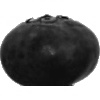

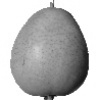

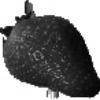

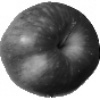

In [3]:
# Get training and test data
images, targets = get_data('fruit_dataset/small_train')
X_test, y_test = get_data('fruit_dataset/small_test')
print(len(X_test), 'test images loaded.')
print(len(images), ' training pictures loaded. Examples: ')
# Visualize Several Images
display(Image.fromarray(images[0].reshape(100,100)))
display(Image.fromarray(images[500].reshape(100,100)))
display(Image.fromarray(images[1000].reshape(100,100)))
display(Image.fromarray(images[1500].reshape(100,100)))

### 3. Data Reduction

#### 3.1 Linear Dimensionality Reduction PCA

In [ ]:
# manipulated from Sebastian Raschka Example (your book!)
# also from hi blog here: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

# this is a scree plot
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook

    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)

    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
                 ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })


In [ ]:
from sklearn.decomposition import PCA

X = images
y = targets
n_components = 300

pca = PCA(n_components=n_components)
%time pca.fit(X.copy())
plot_explained_variance(pca)

As we can see from the figure above, at around 150 components we can explain about 96% of the variation, and the graph begins to become extremely flat. With 300 components the explained variance gets up to 97.7%, but we found that 150 components is all that is needed to get accurate results.

#### 3.2 Linear Dimensionality Reduction Randomized PCA

In [ ]:
rand_pca = PCA(n_components=n_components, svd_solver='randomized')
%time rand_pca.fit(X.copy())
plot_explained_variance(rand_pca)

Again we can see from the figure above, at around 150 components we can explain about 96% of the variation. With 300 components the explained variance gets up to 97.7%, but we found that 150 components is all that is needed to get accurate results.

#### 3.3 Compare PCA and Randomized PCA

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import copy

# get training PCA features
pca_features = pca.transform(copy.deepcopy(X))
rand_pca_features = rand_pca.transform(copy.deepcopy(X))

# transform test data
pca_test = pca.transform(copy.deepcopy(X_test))
rand_pca_test = rand_pca.transform(copy.deepcopy(X_test))

#get KNN accuracy
knn_pca = KNeighborsClassifier(n_neighbors=1)
knn_random_pca = KNeighborsClassifier(n_neighbors=1)

knn_pca.fit(pca_features,y)
acc_pca = accuracy_score(knn_pca.predict(pca_test),y_test)

knn_random_pca.fit(rand_pca_features,y)
acc_rand_pca = accuracy_score(knn_random_pca.predict(rand_pca_test),y_test)

print(f"PCA accuracy:{100*acc_pca:.2f}%, Random PCA Accuracy:{100*acc_rand_pca:.2f}%".format())

From the graphs of explained variance, along with actual classification performance of the two methods, we can see that there is not a very large difference between using PCA vs randomized PCA for this dataset. At 300 components, they have an explained variance difference of just 0.0001%. The PCA did seem to classify very slightly more accurately, but took longer to calculate. Randomized PCA would be better to use because of the slight performance increase, especially if we were using larger images and datasets. Neither one of these methods meets the 94% accuracy that we would hope for when classifying these images.

#### 3.4 DAISY - Feature Extraction

In [ ]:
from skimage.feature import daisy
from skimage.io import imshow

img = Image.fromarray(images[0].reshape(100,100))

# Visualize what the daisy descriptor looks like
features, img_desc = daisy(img, step=20, radius=25, rings=2, histograms=8, orientations=8, visualize=True)
imshow(img_desc)
plt.grid(False)

In [ ]:
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=20, radius=25, rings=2, histograms=8, orientations=8, visualize=False)
    return feat.reshape((-1))

In [ ]:
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (100,100))
print(daisy_features.shape)

In [ ]:
knn_dsy = KNeighborsClassifier(n_neighbors=1)

#fit test data
dsy_test = np.apply_along_axis(apply_daisy, 1, X_test, (100,100))

knn_dsy.fit(daisy_features,y)
acc_dsy = accuracy_score(knn_dsy.predict(dsy_test),y_test)

print(f"PCA accuracy:{100*acc_pca:.2f}%, Daisy Accuracy:{100*acc_dsy:.2f}%".format())

From our nearest neighbor classifier, we can see that DAISY only slightly outperforms our PCA accuracy. A 92.66% accuracy isn't horrible, but it is likely worse than a human would perform for the given fruits, and it still doesn' meet the 94% that Google image recognition meets. Tweaking the step, radius, could allow for more accuracy, but increasing the step and decreasing the radius can make the DAISY calculation very slow.

### 4. DAISY - Key Point Matching

In [ ]:
# Code taken directly from exceptional credit section of Image Data notebook
from skimage.feature import match_descriptors

def apply_daisy(row,shape): # no reshape in this function
    feat = daisy(row.reshape(shape), step=10, radius=10,
                 rings=1, histograms=8, orientations=4,
                 visualize=False)
    s = feat.shape # PxQxR
    #P = ceil((Height - radius*2) / step)
    #Q = ceil((Width - radius*2) / step)
    #R = (rings * histograms + 1) * orientations
    return feat.reshape((s[0]*s[1],s[2]))

d1 = apply_daisy(X[0],(100,100))
d2 = apply_daisy(X[1],(100,100))
d3 = apply_daisy(X[1000],(100,100))
print(d1.shape, d2.shape, d3.shape)
print('Classes:',y[0],y[1],y[1000])

# return list of the key points indices that matched closely enough
matches = match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
print(f"Number of matches, same class: {matches.shape[0]}, Percentage:{100*matches.shape[0]/len(d1):0.2f}%")

# return list of the key points indices that matched closely enough
matches = match_descriptors(d1, d3, cross_check=True, max_ratio=0.8)
print(f"Number of matches, diff classes: {matches.shape[0]}, Percentage:{100*matches.shape[0]/len(d1):0.2f}%")

In [ ]:
# get smaller tst and train dataset 
X, y = get_data('fruit_dataset/tiny_train')
X_test, y_test = get_data('fruit_dataset/tiny_test')
#get key points of test and train data
key_point_train = np.apply_along_axis(apply_daisy, 1, X, (100,100))
key_point_test = np.apply_along_axis(apply_daisy, 1, X_test, (100,100))
print(key_point_train.shape)
print(key_point_test.shape)

In [ ]:
# function returns a list of the indexes of closest image in the training set to each given element of the test set
def get_matches(train,test):
    idxList = []
    for i in range(test.shape[0]):
        max = 0.0
        idx = 0
        for j in range(train.shape[0]):
            matches = match_descriptors(test[i], train[j] , cross_check=True, max_ratio=0.8)
            if matches.shape[0]>max:
                # save index of max match
                max = matches.shape[0]
                idx = j
        idxList.append(idx)
    return idxList
%time idxList = get_matches(key_point_train,key_point_test)


In [ ]:
# find how many were matched correctly
label_list = [y[i] for i in idxList]
count = 0
for k in range(len(label_list)):
    if label_list[k] == y_test[k]:
        count +=1
print(f"Accuracy:{100*count/len(y_test):0.2f}%")

The key point matching does seem to work more accurately than the daisy alone (93.53% vs. 92.66%), but the dataset had to be greatly reduced in order to perform the brute force matching that was implemented in the code above. While an accuracy of 93.53% might seem good, and it is very close to the desired 94%, the training dataset was reduced to about 1900 images of just 4 types of fruit vs. the original 7000 with 13 types of fruit. The runtime was 3 min, and because of the nested for loops used in this method, increasing the size of the training data or test data greatly increases the execution time.